# Supervizionado - Perceptron de multicamadas e Random Forest

In [450]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split
import keras 
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Inicializando base

A base foi inicializada a partir do link do repósitorio hospedado no github que este relatório se encontra.

In [451]:
dataset = pd.read_csv("https://raw.githubusercontent.com/arthuruan/Supervisioned-RNA-RandomForest/master/hcvdata.csv", sep = ',')

dataset

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610,611,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,612,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
612,613,3=Cirrhosis,64,f,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0
613,614,3=Cirrhosis,46,f,33.0,NaN,39.0,62.0,20.0,3.56,4.20,52.0,50.0,71.0


## Pré-processamento

Primeiramente iremos fazer o pré-processamento dos data, para obtermos consequentemente melhores resultados.

### Descartando colunas

Ao analisar a tabela acima podemos encontrar o atributo da primeira coluna, na qual possui os Ids que não irá ter grande valor para apredizagem do algorítimo, então iremos descarta-la.

In [452]:
dataset = dataset.drop(['Unnamed: 0'], axis=1)

dataset.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


### Verificando valores nulos

Agora iremos avaliar se a base usada apresenta intâncias nulas. Com o resultado abaixo podemos concluir que os atributos ALB, ALP, ALT, CHOL e PROT todo têm ao menos uma instância nula. Com isso, iremos tratar esses valores.

In [453]:
nullValues = pd.isnull(dataset).sum()

nullValues

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

#### Tratando os valores nulos

Como foi visto posteriormente, temos valores a serem tratados. A partir disso, iremos descartar essas instâncias para um melhor funcionamento do algoritmo.

In [454]:
dataset = dataset.dropna(axis = 0)
pd.isnull(dataset).sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### Separando a base de validação

Será separada da base atual as instâncias que possuem o valor ``` 0s=suspect Blood Donor ``` no atributo ``` category ```, essa nova base será usada para validação da rede.

In [455]:
dataset_sbd = dataset
dataset_sbd = dataset[dataset['Category'] == '0s=suspect Blood Donor']
dataset = dataset[dataset['Category'] != '0s=suspect Blood Donor']
dataset_sbd

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
533,0s=suspect Blood Donor,47,m,22.5,124.0,79.5,46.7,2.3,6.83,4.30,170.0,345.6,58.6
534,0s=suspect Blood Donor,48,m,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29.0,83.0,47.8
535,0s=suspect Blood Donor,49,m,21.6,42.2,9.5,10.6,2.4,3.75,3.01,64.0,38.9,44.8
536,0s=suspect Blood Donor,55,m,47.3,106.0,208.8,130.6,0.8,14.80,8.08,76.0,71.6,78.3
537,0s=suspect Blood Donor,71,m,14.9,69.8,19.7,95.2,9.8,13.30,2.61,9.0,7.6,47.0
538,0s=suspect Blood Donor,74,m,20.3,84.0,22.8,43.0,5.7,4.91,3.19,52.0,218.3,47.8
539,0s=suspect Blood Donor,59,f,19.3,208.2,325.3,146.6,6.9,5.33,4.72,32.0,295.6,53.1


### One Hot Encoding

Para que possamos obter resultados melhores e que a rede não se confunda na parte de aprendizagem, vamos fazer o **one hot encoding** das instâncias do atributo ```category```. Dessa forma, vamos transformar os valores de **Doador** como 1, no qual são representados pelo valor de instância ``` 0=Blood Donor ``` e os valores de **Não Doador** como 0, no qual são representados pelo valor de intância ```1=Hepatitis```, ```2=Fibrosis``` e ```3=Cirrhosis```. De maneira análoga, vamos fazer o mesmo para o atributo ```Sex```.

In [456]:
encoder = LabelEncoder()
dataset['Category'] = encoder.fit_transform(dataset['Category'] == '0=Blood Donor')
dataset['Sex'] = encoder.fit_transform(dataset['Sex'])

dataset_sbd['Sex'] = encoder.fit_transform(dataset_sbd['Sex'])

print(dataset)

print(dataset_sbd)

     Category  Age  Sex   ALB    ALP  ...    CHE  CHOL   CREA    GGT  PROT
0           1   32    1  38.5   52.5  ...   6.93  3.23  106.0   12.1  69.0
1           1   32    1  38.5   70.3  ...  11.17  4.80   74.0   15.6  76.5
2           1   32    1  46.9   74.7  ...   8.84  5.20   86.0   33.2  79.3
3           1   32    1  43.2   52.0  ...   7.33  4.74   80.0   33.8  75.7
4           1   32    1  39.2   74.1  ...   9.15  4.32   76.0   29.9  68.7
..        ...  ...  ...   ...    ...  ...    ...   ...    ...    ...   ...
608         0   58    0  34.0   46.4  ...   6.26  3.98   56.0   49.7  80.6
609         0   59    0  39.0   51.3  ...   5.77  4.51  136.1  101.1  70.5
610         0   62    0  32.0  416.6  ...   5.57  6.30   55.7  650.9  68.5
611         0   64    0  24.0  102.8  ...   1.54  3.02   63.0   35.9  71.3
612         0   64    0  29.0   87.3  ...   1.66  3.63   66.7   64.2  82.0

[582 rows x 13 columns]
                   Category  Age  Sex   ALB  ...  CHOL   CREA    GGT  PROT


### Verificando se a base está balanceada

Este é um passo importante, então vamos analisar com cuidado 🤨. Bases desbalanceadas é um problema muito recorrente, até mesmo em grande empresas sofrem com isso, por exemplo o Twitter que foi fortemente criticado, pois o  algoritmo de reconhecimento facial dava prioridade a pessoas brancas, problema esse que pode ter sido acarretado por bases de treinamento mal balanceadas.

Indubitavelmente, teremos que aplicar esse pré-processamento na nossa base. Primeiro será necessário a verificação na base se os atributos da base estão balanceados, vamos começar pelo ```Category```.

In [457]:
dataset.groupby('Category').count()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Category,,,,,,,,,,,,
0,56,56,56,56,56,56,56,56,56,56,56,56
1,526,526,526,526,526,526,526,526,526,526,526,526


Ao se analisar a tabela a cima é bem perceptível que a instância 1, que representa os doadores, possui cerca de 470 mais valores em todos os outros atributos em relação a isntância 0, que representa os não doadores. Desse modo, confirmamos que nossa base está desbanlanceada, então bora tratar isso? A maneira mais simples de fazer esse tratamento será retirar esses 470 valores para que a base esteja balanceada, outra forma seria na geração de dados da instância 0. Porém iremos pelo caminho mais simples, vamos agora retirar esses valores que possuem sobras.

In [458]:
dataset.drop(dataset.head(470).index, inplace = True) 
dataset

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
476,1,53,0,43.7,84.3,18.8,18.6,8.5,10.22,6.65,56.0,16.5,76.9
477,1,53,0,43.5,61.7,16.9,20.3,7.0,7.19,6.97,74.0,12.3,69.2
478,1,53,0,41.1,91.7,13.8,19.6,3.4,7.87,5.48,72.0,77.3,77.3
479,1,53,0,38.0,84.7,23.5,19.8,10.8,7.30,4.82,62.0,11.4,68.5
480,1,53,0,47.4,66.9,24.3,32.6,14.9,10.51,6.03,81.0,25.2,75.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,0,58,0,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
609,0,59,0,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
610,0,62,0,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,0,64,0,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3


Após essa retirada teremos que confirmar que a base está totalmente balanceada. Agora podemos afirmar que a base está balanceada e seguir para o próximo passo.

In [459]:
dataset.groupby('Category').count()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Category,,,,,,,,,,,,
0,56,56,56,56,56,56,56,56,56,56,56,56
1,56,56,56,56,56,56,56,56,56,56,56,56


### Verificando Correlação

O próximo passo a ser dado será a verificação de correlação entre os atributos. Dependendo do resultado poderemos remover dados com alta correlação ou até mesmo agregando esses atributos. Após a veficação da plotagem do gráfico percebemos que o os atributos que possuem o maior valor de auto correlação são o ```ALB``` e ```CHE```, cerca de 65%, porém não será necessário o tratamento desses atributos por não possuir uma correlação tão alta, não ultrapassando os 80%. 

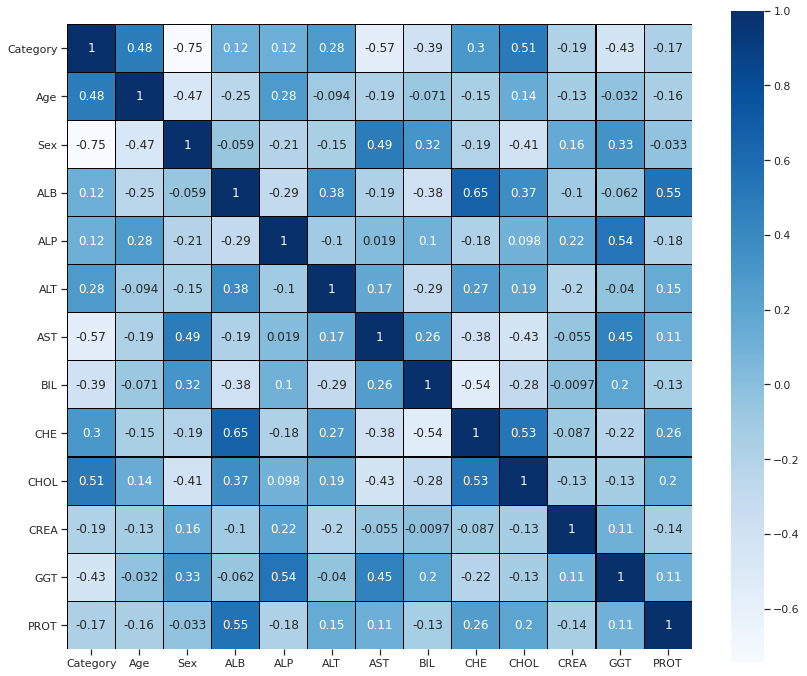

In [460]:
sn.set(style='ticks', color_codes=True)
plt.figure(figsize=(14, 12))
sn.heatmap(dataset.corr(), 
          linewidths=0.1, 
          square=True, 
          linecolor='black', 
          annot=True,
          cmap='Blues')

plt.show()

### Verificando outliers

Neste passo será a verificação e tratamento de outliers que acabam contribuindo negativamente para aprendizagem do nosso algoritmo.

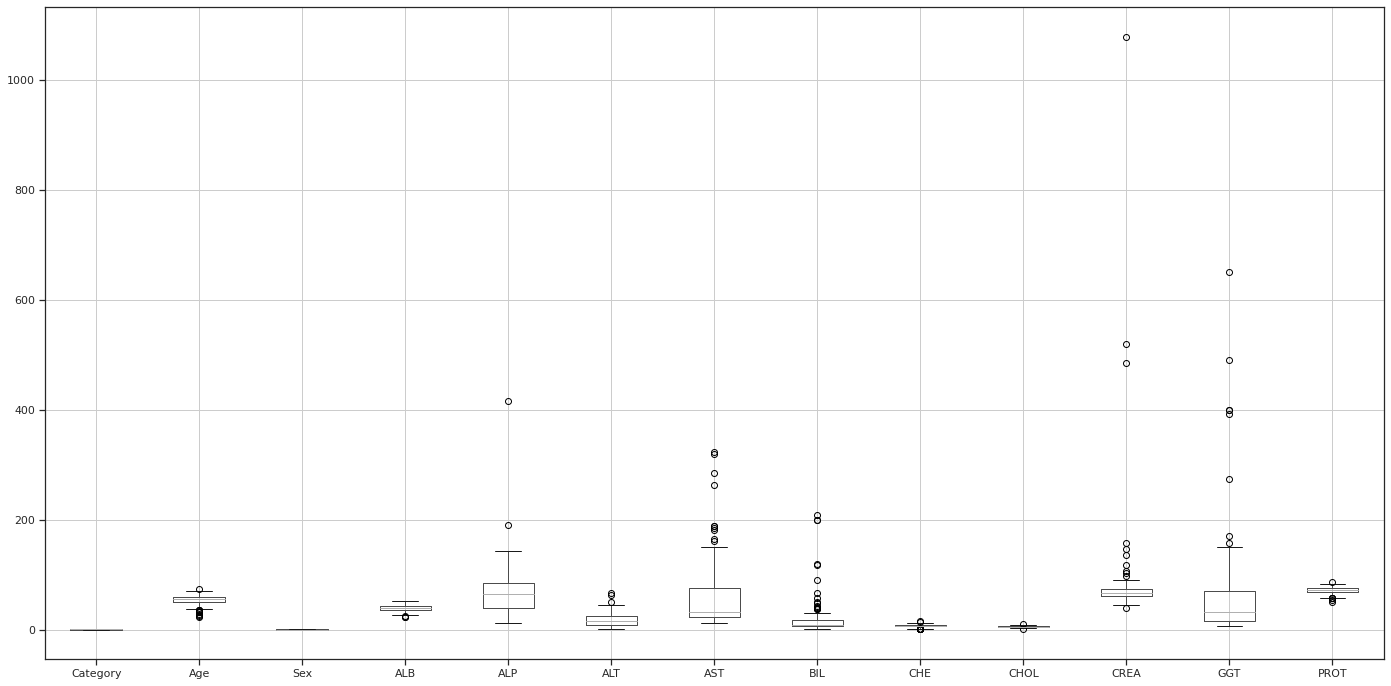

In [461]:
dataset.boxplot(figsize=(24,12))

A partir da verficação do gráfico acima, conseguimos identificar vários outliers. Assim, temos que fazer o tratamento desses outliers, aplicando uma função de normalização de dados, que será melhor explicada no próximo e último tópico de pré-processamento.

### Normalizando a base

Para normalizar a base foi usado a função Standard Scaler, pois ela padroniza os recursos removendo a média e escalonando para a variação da unidade. O principal motivo para o uso dessa normalização foi porque a padronização de um conjunto de dados é um requisito comum para muitos estimadores de aprendizado de máquina.

In [462]:
column_mean = dataset.mean()
column_std = dataset.std()

dataset_transformed = (dataset - column_mean) / column_std

dataset_transformed['Category'] = encoder.fit_transform(dataset_transformed['Category'])

## Perceptron de multicamadas

Para a contrução da RNA precisamos obter os valores de previsões e classe

In [478]:
dataset_predict = dataset.iloc[:, 1:14]
dataset_class = dataset.iloc[:, 0]

dataset_transformed_previous = dataset_transformed.iloc[:, 1:14]
dataset_transformed_class = dataset_transformed.iloc[:, 0]

### Subdividindo a base de dados

Primeiramente para começarmos o treinamento, temos que subvidir nossa base de dados em treinamento e teste. A partir desse pressuposto, iremos dividir cerca de 20% para teste e 80% da base de dados para o treinamento da rede, vamo nessa!

In [479]:
train_previous, test_previous, train_class, test_class = train_test_split(dataset_predict, dataset_class, random_state = 0, test_size = 0.20)

### Criando a RNA

Vamos construir nosso modelo ultizando o keras, será uma rede totalemente conectada. Primeiro será necessário a construção da camada de entrada, das camadas ocultas e da camada de saída.

In [480]:
model = Sequential()
model.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'random_uniform', input_dim = 12))
model.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'random_uniform'))
model.add(Dense(units = 1, activation = 'sigmoid'))

Agora iremos executar nosso modelo.

In [481]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

### Treinando a rede

Após o modelo ter sido criado iremos treina-los. Será usada 18 épocas, pois a partir dela teremos um overfitting. Apesar de conseguir um resultado bom no treinamento temos que validar o modelo, isso será melhor demonstrado no próximo tópico.

In [482]:
model.fit(train_previous, train_class, batch_size = 5, epochs = 18)

Epoch 1/18
18/18 [==============================] - 0s 1ms/step - loss: 0.6261 - binary_accuracy: 0.7416
Epoch 2/18
18/18 [==============================] - 0s 1ms/step - loss: 0.4895 - binary_accuracy: 0.8315
Epoch 3/18
18/18 [==============================] - 0s 948us/step - loss: 0.3863 - binary_accuracy: 0.8989
Epoch 4/18
18/18 [==============================] - 0s 1ms/step - loss: 0.3080 - binary_accuracy: 0.9101
Epoch 5/18
18/18 [==============================] - 0s 2ms/step - loss: 0.2472 - binary_accuracy: 0.9101
Epoch 6/18
18/18 [==============================] - 0s 1ms/step - loss: 0.2110 - binary_accuracy: 0.9213
Epoch 7/18
18/18 [==============================] - 0s 1ms/step - loss: 0.1764 - binary_accuracy: 0.9551
Epoch 8/18
18/18 [==============================] - 0s 1ms/step - loss: 0.1534 - binary_accuracy: 0.9326
Epoch 9/18
18/18 [==============================] - 0s 1ms/step - loss: 0.1261 - binary_accuracy: 0.9551
Epoch 10/18
18/18 [==============================] - 

### Validando o modelo

Neste tópico iremos verificar se nosso modelo consegue bons resultados com dados diferentes do treinado, com isso, iremos valida-lo. Com o resultado obtido abaixo, percebemos que estamos com resultados bons, demonstrando que a rede está conseguindo generalizar bem.

In [483]:
validation = model.evaluate(test_previous, test_class)

1/1 [==============================] - 0s 2ms/step - loss: 0.0965 - binary_accuracy: 0.9565


### Plotando resultados

Vamos mostrar agora os resultados obtidos, é importante lembrar que estamos usando a base não normalizada, posteriormente os resultados com a base normalizada será mostrado. 

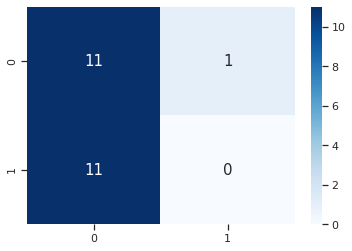

In [473]:
predictions = model.predict(test_predict)
predictions = (predictions > 0.5)

ax = confusion_matrix(test_class, predictions)
df = pd.DataFrame(ax, range(2), range(2))
sn.heatmap(df, annot=True, annot_kws={"size": 15}, cmap='Blues')

In [474]:
sens = (11 / (0 + 11))
print('Sensibilidade', sens * 100, '%')
espe = (11 / (11 + 1))
print('Especificidade', espe * 100, '%')

Sensibilidade 100.0 %
Especificidade 91.66666666666666 %


Analisando a matriz de confusão percebemos que o modelo conseguiu ter resultados bastante animadores. Assim o modelo conseguiu classificar 11 de 12 instâncias da classe não doador e 100% das instâncias da classe doador.

### Resultados da base normalizada

Analogamente todos passos usados na base não normalizada, foi aplicado na base normalizada

In [467]:
train_predict_N, test_predict_N, train_class_N, test_class_N = train_test_split(
    dataset_transformed_previous, 
    dataset_transformed_class, 
    random_state = 0, 
    test_size = 0.20)

modelN = Sequential()
modelN.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'random_uniform', input_dim = 12))
modelN.add(Dense(units = 6, activation = 'relu', kernel_initializer = 'random_uniform'))
modelN.add(Dense(units = 1, activation = 'sigmoid'))

modelN.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['binary_accuracy'])

modelN.fit(train_predict_N, train_class_N, batch_size = 5, epochs = 20)

Epoch 1/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6938 - binary_accuracy: 0.4382
Epoch 2/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6932 - binary_accuracy: 0.5056
Epoch 3/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6929 - binary_accuracy: 0.5056
Epoch 4/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6924 - binary_accuracy: 0.5056
Epoch 5/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6912 - binary_accuracy: 0.5056
Epoch 6/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6886 - binary_accuracy: 0.5056
Epoch 7/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6838 - binary_accuracy: 0.5056
Epoch 8/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6750 - binary_accuracy: 0.5506
Epoch 9/20
18/18 [==============================] - 0s 1ms/step - loss: 0.6531 - binary_accuracy: 0.9213
Epoch 10/20
18/18 [==============================] - 0s

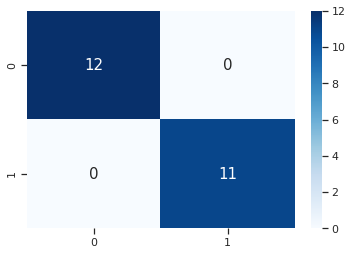

In [469]:
predictions_N = modelN.predict(test_predict_N)
predictions_N = (predictions > 0.5)

ax2 = confusion_matrix(test_class, predictions_N)
df = pd.DataFrame(ax, range(2), range(2))
sn.heatmap(df, annot=True, annot_kws={"size": 15}, cmap='Blues')

In [475]:
sens = (11 / (0 + 11))
print('Sensibilidade', sens * 100, '%')
espe = (12 / (12 + 0))
print('Especificidade', espe * 100, '%')

Sensibilidade 100.0 %
Especificidade 100.0 %


Fazendo análise dos dados acima conseguimos identificar que os resultados da base normalizada em oposição aos resultados da não normalizada são bastante parecidos, mostrando que a normalização não foi de grande ajuda para o treinamento da rede.

### Classificando as instâncias da base dataset_sbd

Nesta última análise, iremos classificar as instâncias da base separa no início do relatório, base essa que contém a instância ```suspect Blood Donor```, ao observar os valores preditos abaixo conseguimos identificar que a rede classificou relativamente bem as instâncias, msotrando que ela conseguiu generalizar bem outros dados.



In [342]:
preditcs_sbd = dataset_sbd.iloc[:, 1:14]
preditcs_sbd = model.predict(preditcs_sbd)
preditcs_sbd = (preditcs_sbd > 0.5)
preditcs_sbd

array([[False],
       [ True],
       [ True],
       [ True],
       [False],
       [False],
       [ True]])

## Random forest

Algoritmo que cri várias árvores de descisão de maneira aleatória, onde cada árvore será utilizada na escolha do resultado final.

### Subdividindo base de dados

Vamos treinar o algoritmo, já que posteriormente já foram criados os valores de previsões e classe, vamos usar ele aqui também. Usando 80% para treinamenteo e 20% para teste.

In [431]:
train_predict_RF, test_predict_RF, train_class_RF, test_class_RF = train_test_split(dataset_predict,
                                                                                    dataset_class,
                                                                                    random_state = 0, 
                                                                                    test_size = 0.20)

### Classificador

Nesta parte criamos o classificador através da biblioteca ```RandomForestClassifier```.

In [432]:
classifier = RandomForestClassifier(n_estimators = 30,
                                    criterion = 'entropy', random_state = 0)

### Treinando classificador


A partir dos valores de predição e classe que conseguimos no passo de subdivisão da base, vamos treinar o classificador. 

In [433]:
classifier.fit(train_predict_RF, train_class_RF)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### Resultados do algoritmo

Primeiro vamos verificar a predição da rede de acordo com subdivisão feita e logo após iremos verificar a acurácia do algoritmo.

In [443]:
preditcs_RF = classifier.predict(test_predict_RF)
preditcs_RF = (preditcs_RF > 0.5)
preditcs_RF

array([ True,  True,  True, False, False,  True, False,  True, False,
        True,  True, False, False, False, False, False,  True,  True,
       False,  True,  True, False, False])

In [446]:
result = round(accuracy_score(test_class_RF, preditcs_RF), 2)
print('Acurácia:', result)

Acurácia: 1.0


Obtemos uma acurácia de 100%, isso quer dizer que nosso modelo está com uma ótima acurácia, ótima até demais.

### Plotando resultados 

Iremos agora plotar os resultados da base não normalizada. De acordo com o gráfico abaixo, o algoritmo mostrou ter bons resultados.

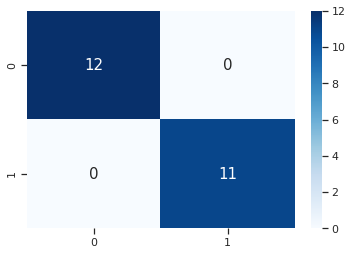

In [447]:
ax = confusion_matrix(preditcs_RF, test_class_RF)
df = pd.DataFrame(ax, range(2), range(2))
sn.heatmap(df, annot=True, annot_kws={"size": 15}, cmap='Blues')

In [449]:
sens = (11 / (0 + 11))
print('Sensibilidade', sens * 100, '%')
espe = (12 / (12 + 0))
print('Especificidade', espe * 100, '%')

Sensibilidade 100.0 %
Especificidade 100.0 %


### Resultados com a base normalizada

Assim como RNA foi usado os mesmos passos para o treinamento e os resultados não tiveram diferença perceptível. Tendo Acurácia, sensibilidade e especificidade de 100% assim como a não normalizada.

### Classificando as instâncias da base dataset_sbd


Assim como no algoritmo vamos analisar o resultado da rede com a base que possuem apenas as instâncias ```suspect Blood Donor```.

In [442]:
dataset_sbd

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
533,0s=suspect Blood Donor,47,1,22.5,124.0,79.5,46.7,2.3,6.83,4.30,170.0,345.6,58.6
534,0s=suspect Blood Donor,48,1,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29.0,83.0,47.8
535,0s=suspect Blood Donor,49,1,21.6,42.2,9.5,10.6,2.4,3.75,3.01,64.0,38.9,44.8
536,0s=suspect Blood Donor,55,1,47.3,106.0,208.8,130.6,0.8,14.80,8.08,76.0,71.6,78.3
537,0s=suspect Blood Donor,71,1,14.9,69.8,19.7,95.2,9.8,13.30,2.61,9.0,7.6,47.0
538,0s=suspect Blood Donor,74,1,20.3,84.0,22.8,43.0,5.7,4.91,3.19,52.0,218.3,47.8
539,0s=suspect Blood Donor,59,0,19.3,208.2,325.3,146.6,6.9,5.33,4.72,32.0,295.6,53.1


In [445]:
preditcs_sbd = dataset_sbd.iloc[:, 1:14]
preditcs_sbd = classifier.predict(preditcs_sbd)
preditcs_sbd = (preditcs_sbd > 0.5)
preditcs_sbd

array([False,  True, False, False, False, False, False])

Após a comparação com o algoritmo anterior, conseguimos perceber uma diferença de resultado. Mostrando que classificador não foi predeterminado para as instâncias ```suspect Blood Donor```.